# E23CSEU0055 - Arihant Gupta - EB02 - Lab_05 - Time Series Analysis

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.signal import butter, lfilter
import numpy as np

In [71]:
df = pd.read_csv("ep.csv")
df["DATE"] = pd.to_datetime(df["DATE"])
print(df)

          DATE  IPG2211A2N
0   1985-01-01     72.5052
1   1985-02-01     70.6720
2   1985-03-01     62.4502
3   1985-04-01     57.4714
4   1985-05-01     55.3151
..         ...         ...
392 2017-09-01     98.6154
393 2017-10-01     93.6137
394 2017-11-01     97.3359
395 2017-12-01    114.7212
396 2018-01-01    129.4048

[397 rows x 2 columns]


In [72]:
df.set_index("DATE", inplace=True)
print(df)

            IPG2211A2N
DATE                  
1985-01-01     72.5052
1985-02-01     70.6720
1985-03-01     62.4502
1985-04-01     57.4714
1985-05-01     55.3151
...                ...
2017-09-01     98.6154
2017-10-01     93.6137
2017-11-01     97.3359
2017-12-01    114.7212
2018-01-01    129.4048

[397 rows x 1 columns]


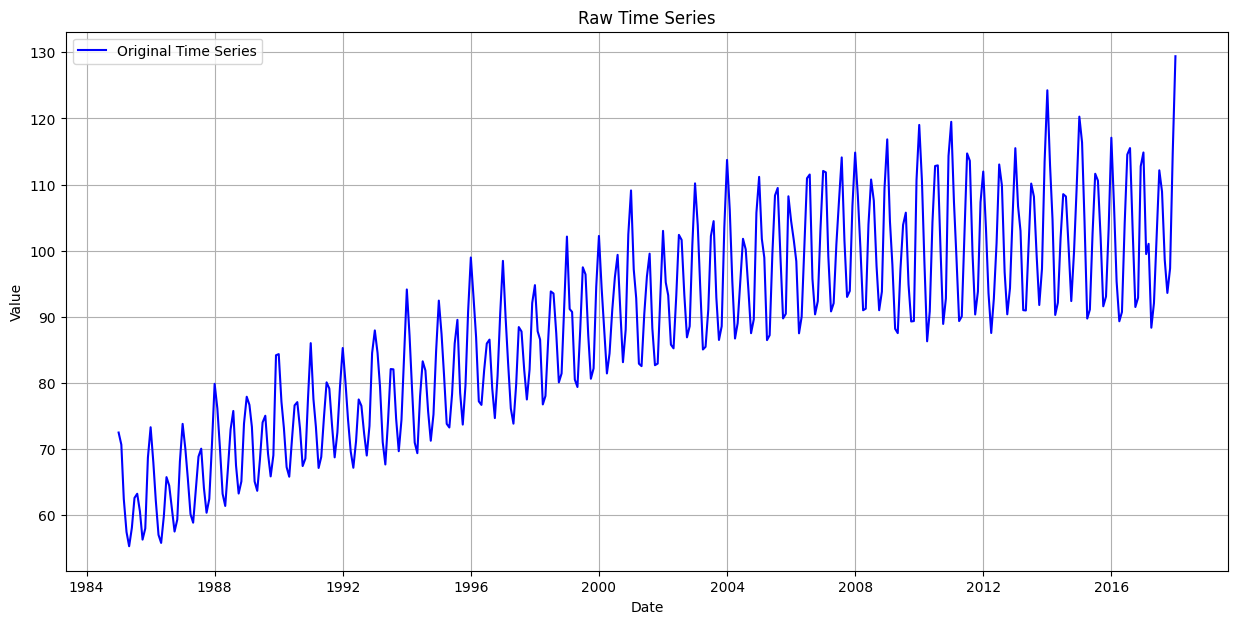

In [73]:
plt.figure(figsize=(15, 7))
plt.plot(df.index, df["IPG2211A2N"], label='Original Time Series', color='blue')
plt.title('Raw Time Series')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

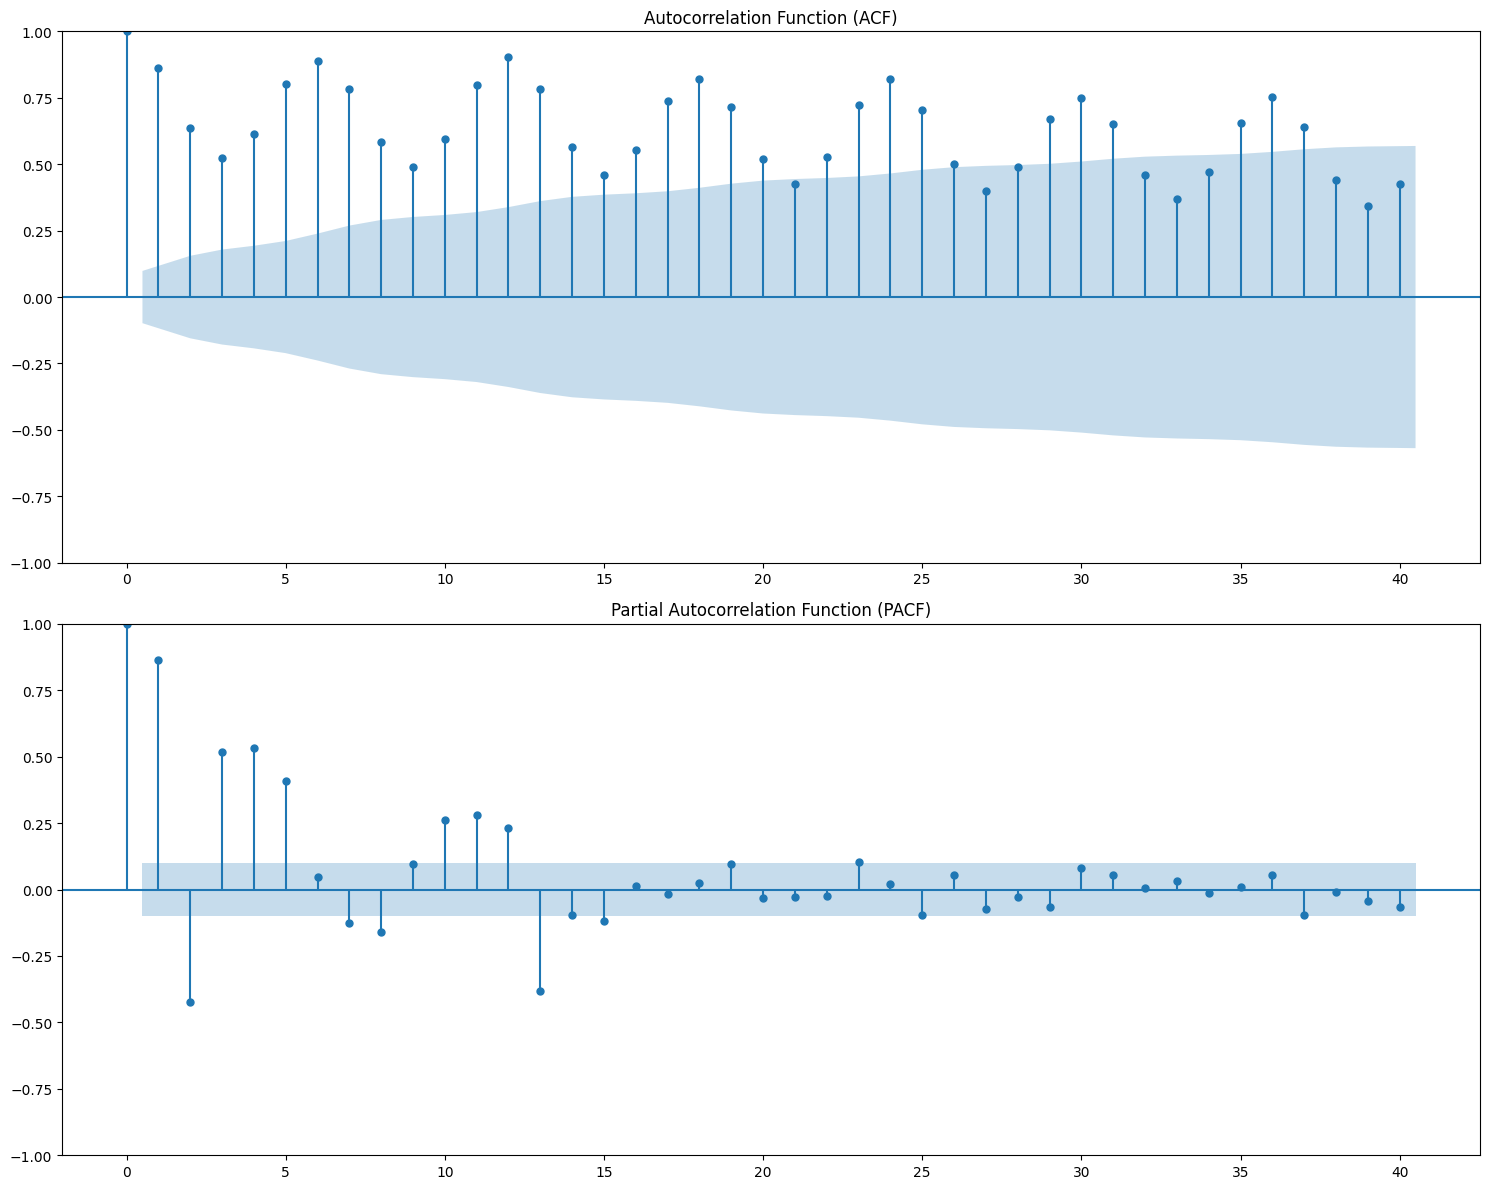

In [75]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
plot_acf(df["IPG2211A2N"], ax=ax1, lags=40, title='Autocorrelation Function (ACF)')
plot_pacf(df["IPG2211A2N"], ax=ax2, lags=40, title='Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()

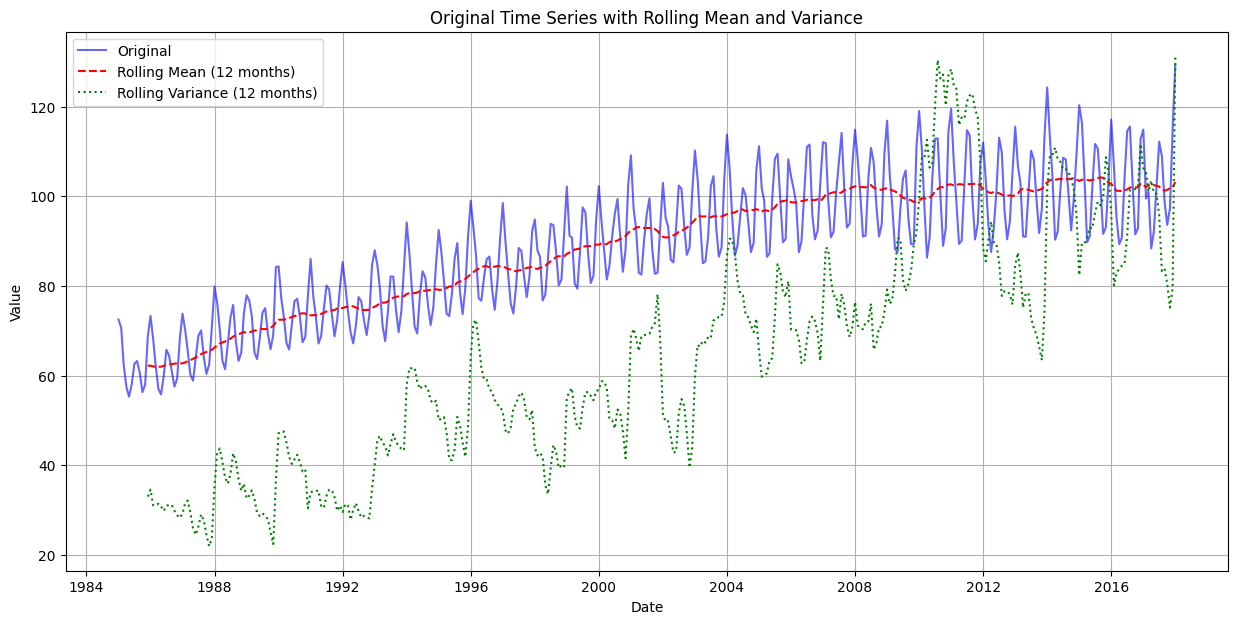

In [76]:
window_size = 12
r_mean = df["IPG2211A2N"].rolling(window=window_size).mean()
r_var = df["IPG2211A2N"].rolling(window=window_size).var()
plt.figure(figsize=(15, 7))
plt.plot(df.index, df["IPG2211A2N"], label='Original', alpha=0.6, color='blue')
plt.plot(r_mean.index, r_mean, label=f'Rolling Mean ({window_size} months)', color='red', linestyle='--')
plt.plot(r_var.index, r_var, label=f'Rolling Variance ({window_size} months)', color='green', linestyle=':')
plt.title('Original Time Series with Rolling Mean and Variance')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

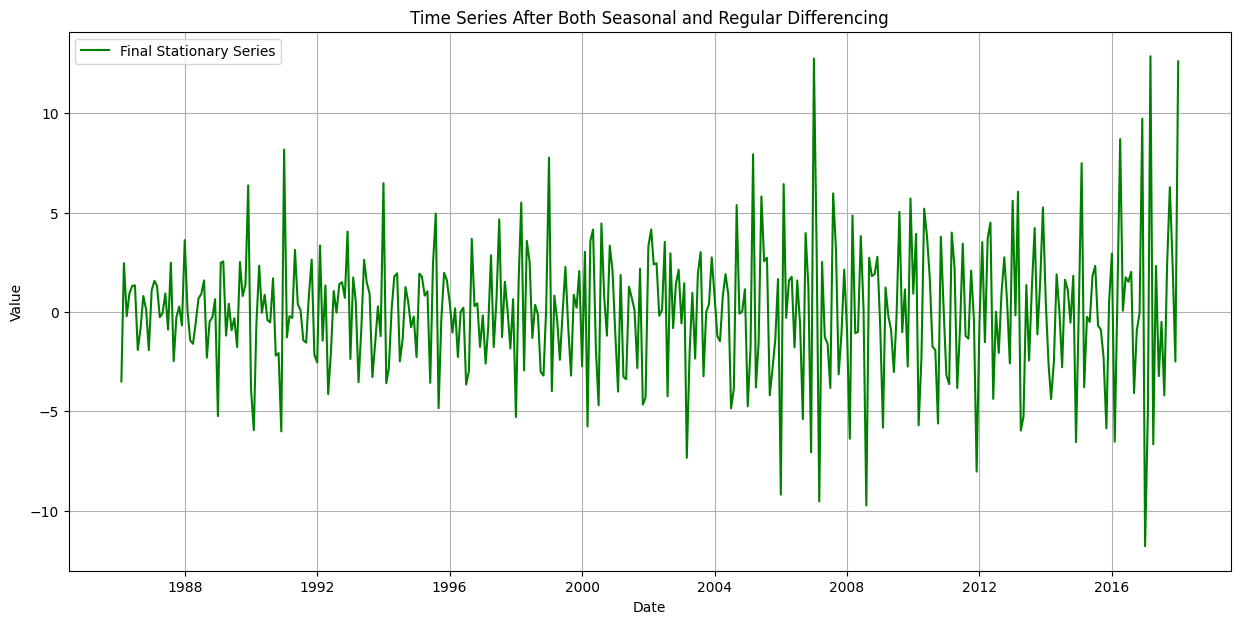

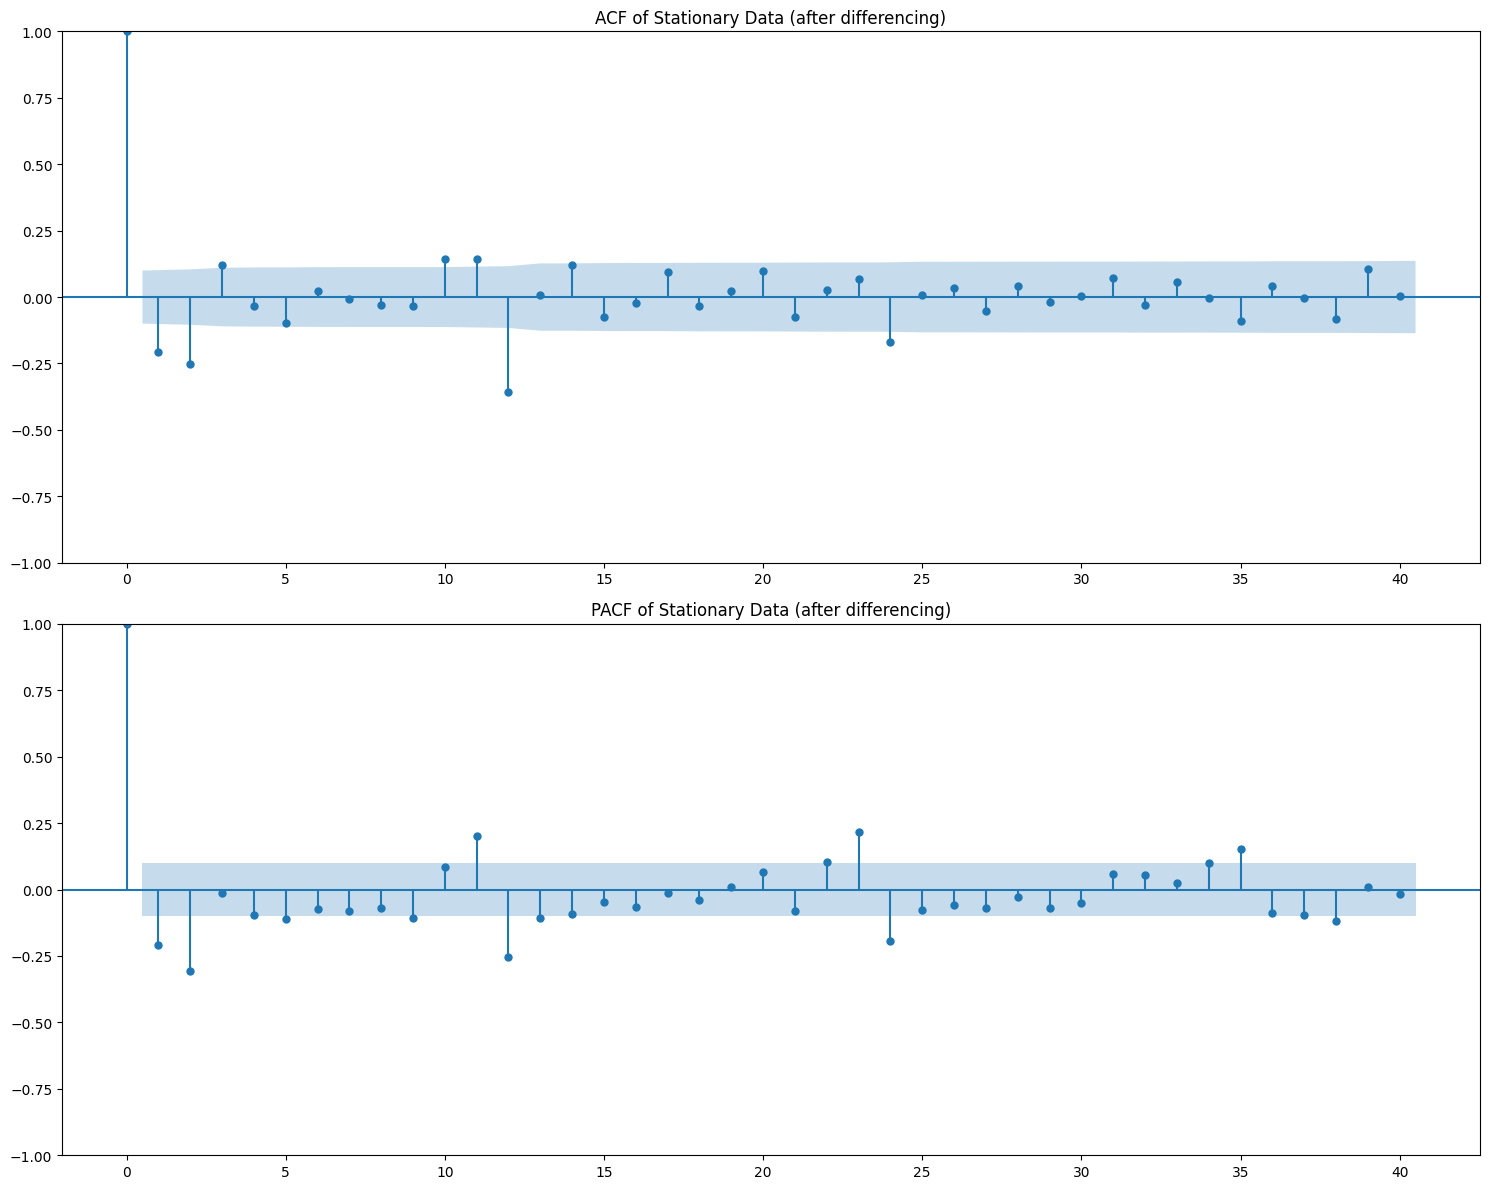

In [77]:
df['seasonal_diff'] = df["IPG2211A2N"].diff(periods=12)
df['final_stationary'] = df['seasonal_diff'].diff()
stationary_series = df['final_stationary'].dropna()

plt.figure(figsize=(15, 7))
plt.plot(stationary_series, label='Final Stationary Series', color='green')
plt.title('Time Series After Both Seasonal and Regular Differencing')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
plot_acf(stationary_series, ax=ax1, lags=40, title='ACF of Stationary Data (after differencing)')
plot_pacf(stationary_series, ax=ax2, lags=40, title='PACF of Stationary Data (after differencing)')
plt.tight_layout()
plt.show()

In [78]:
fdf = pd.DataFrame(index=stationary_series.index)
fdf["DD"] = stationary_series
print(fdf)

                 DD
DATE               
1986-02-01  -3.4856
1986-03-01   2.4570
1986-04-01  -0.2104
1986-05-01   0.9371
1986-06-01   1.3115
...             ...
2017-09-01   2.4364
2017-10-01   6.2753
2017-11-01   2.3189
2017-12-01  -2.4941
2018-01-01  12.6025

[384 rows x 1 columns]


In [81]:
window_size = 5
sma = stationary_series.rolling(window=window_size, min_periods=1).mean()
fdf['SMA'] = sma
print(fdf)

                 DD       SMA      EWMA
DATE                                   
1986-02-01  -3.4856 -3.485600 -3.485600
1986-03-01   2.4570 -0.514300 -1.504733
1986-04-01  -0.2104 -0.413000 -1.073289
1986-05-01   0.9371 -0.075475 -0.403159
1986-06-01   1.3115  0.201920  0.168394
...             ...       ...       ...
2017-09-01   2.4364 -0.635180 -0.448646
2017-10-01   6.2753  0.156680  1.792669
2017-11-01   2.3189  1.266040  1.968079
2017-12-01  -2.4941  0.867540  0.480686
2018-01-01  12.6025  4.227800  4.521291

[384 rows x 3 columns]


In [82]:
ewma = stationary_series.ewm(span=window_size, adjust=False).mean()
fdf['EWMA'] = ewma
print(fdf)

                 DD       SMA      EWMA
DATE                                   
1986-02-01  -3.4856 -3.485600 -3.485600
1986-03-01   2.4570 -0.514300 -1.504733
1986-04-01  -0.2104 -0.413000 -1.073289
1986-05-01   0.9371 -0.075475 -0.403159
1986-06-01   1.3115  0.201920  0.168394
...             ...       ...       ...
2017-09-01   2.4364 -0.635180 -0.448646
2017-10-01   6.2753  0.156680  1.792669
2017-11-01   2.3189  1.266040  1.968079
2017-12-01  -2.4941  0.867540  0.480686
2018-01-01  12.6025  4.227800  4.521291

[384 rows x 3 columns]


In [83]:
def butter_lowpass_filter(data, cutoff, order):
    nyq = 0.5 * 1
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = lfilter(b, a, data)
    return y

order = 2
cutoff_low = 0.1
low_pass_filtered = butter_lowpass_filter(stationary_series, cutoff=cutoff_low, order=order)
fdf['Low_Pass'] = low_pass_filtered
print(fdf)

                 DD       SMA      EWMA  Low_Pass
DATE                                             
1986-02-01  -3.4856 -3.485600 -3.485600 -0.235122
1986-03-01   2.4570 -0.514300 -1.504733 -0.573247
1986-04-01  -0.2104 -0.413000 -1.073289 -0.475990
1986-05-01   0.9371 -0.075475 -0.403159 -0.106846
1986-06-01   1.3115  0.201920  0.168394  0.275067
...             ...       ...       ...       ...
2017-09-01   2.4364 -0.635180 -0.448646 -1.401620
2017-10-01   6.2753  0.156680  1.792669 -0.734983
2017-11-01   2.3189  1.266040  1.968079  0.905894
2017-12-01  -2.4941  0.867540  0.480686  1.906728
2018-01-01  12.6025  4.227800  4.521291  2.475445

[384 rows x 4 columns]


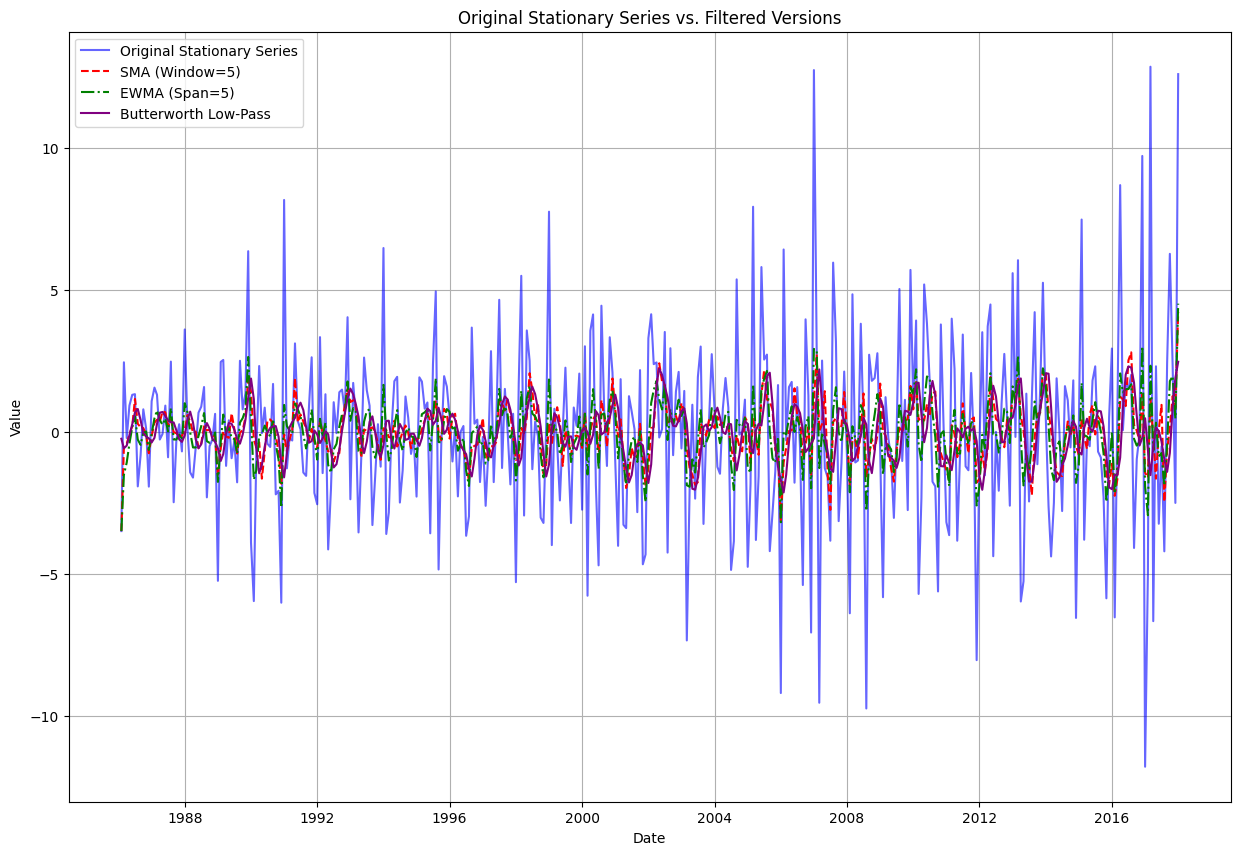


Comparing ACF of original and filtered stationary data...


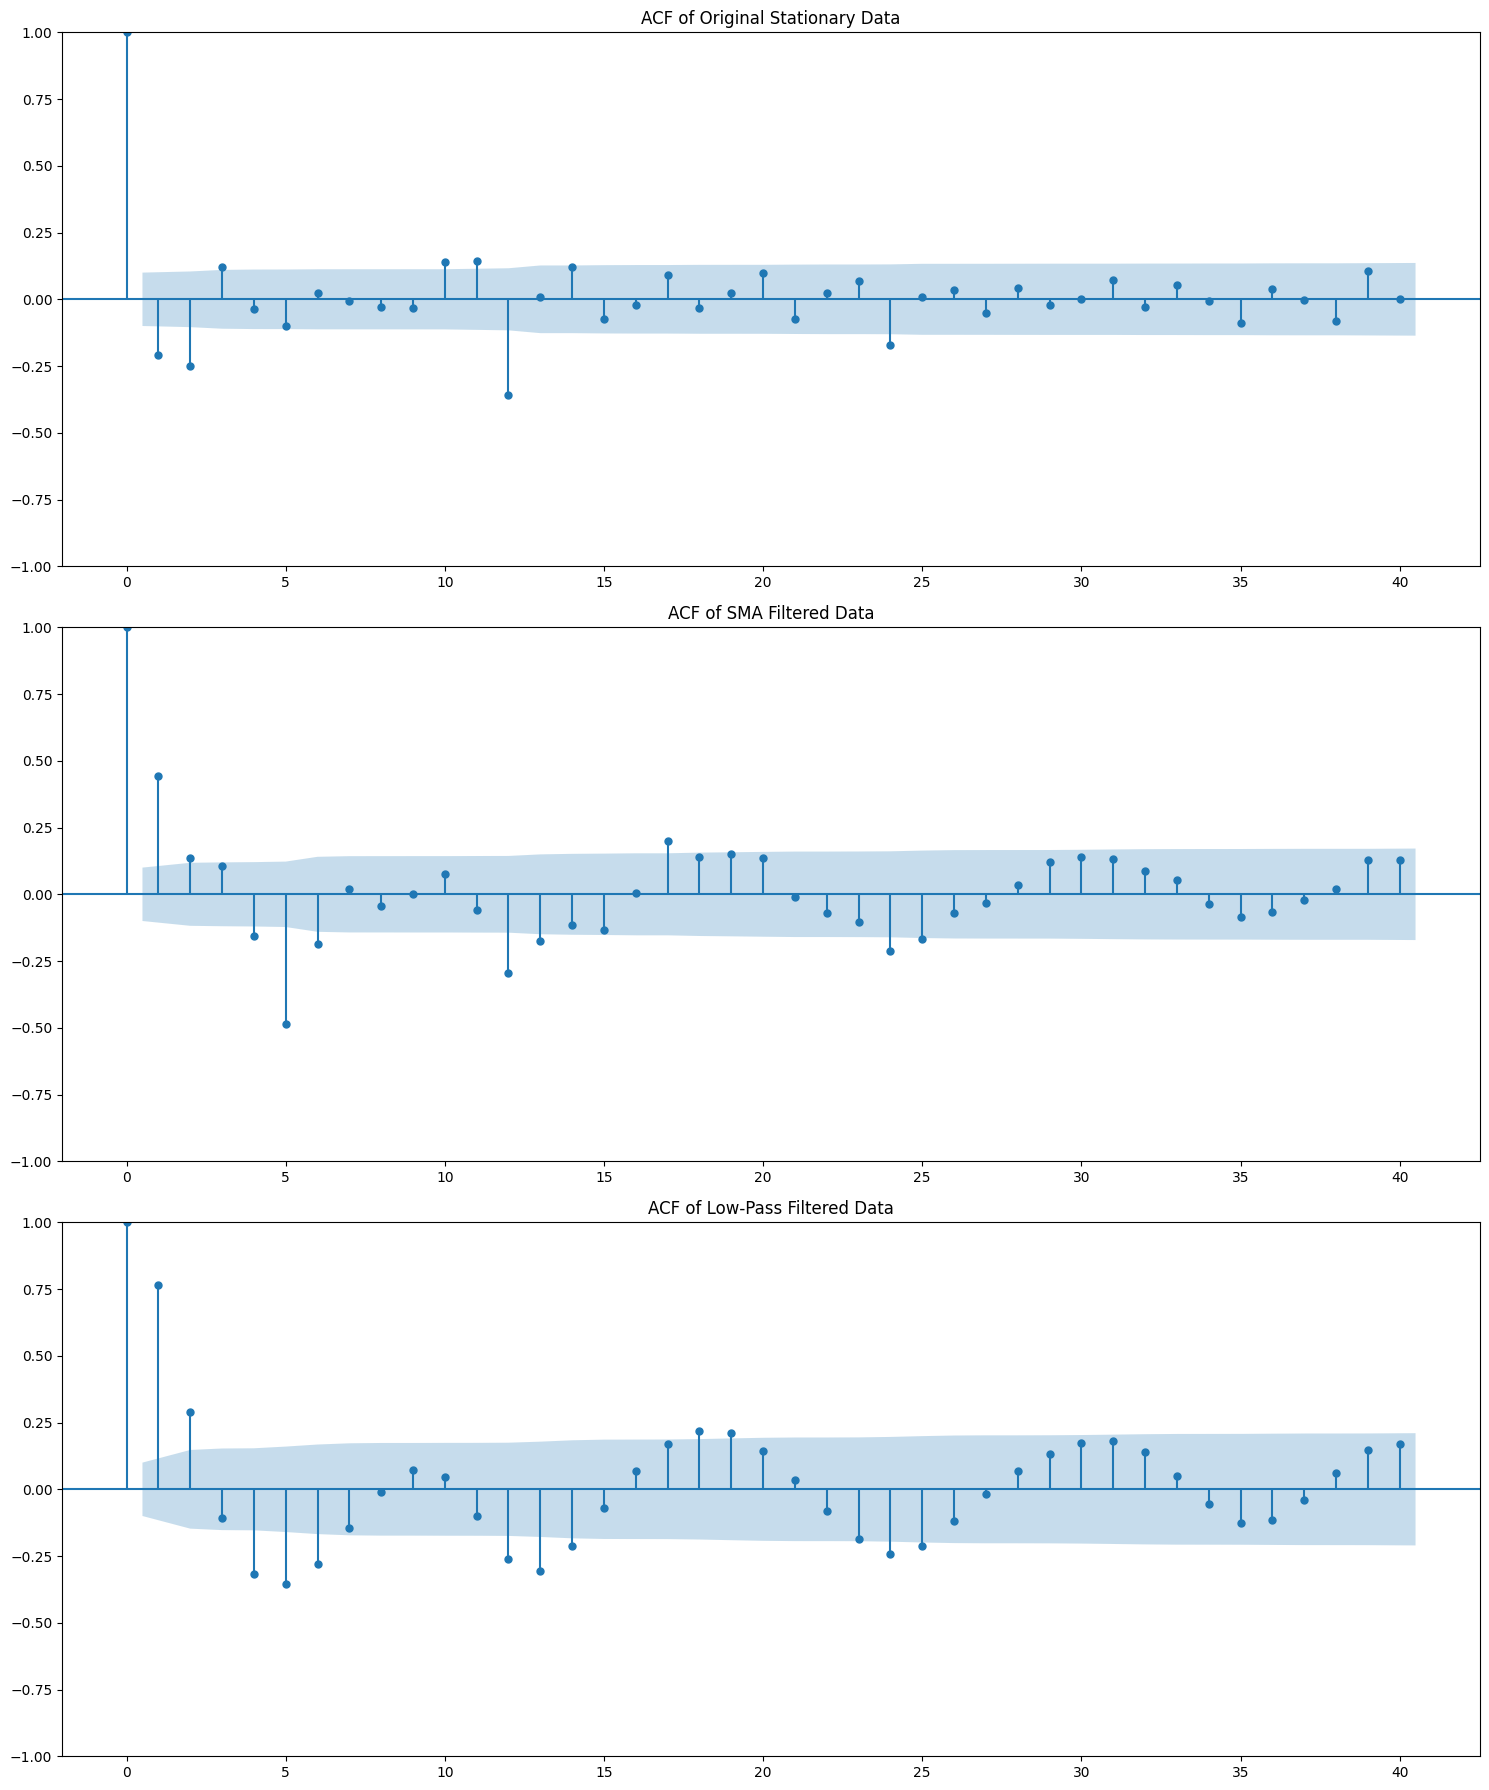

In [88]:
plt.figure(figsize=(15, 10))
plt.plot(fdf.index, fdf['DD'], label='Original Stationary Series', color='blue', alpha=0.6)
plt.plot(fdf.index, fdf['SMA'], label=f'SMA (Window={window_size})', color='red', linestyle='--')
plt.plot(fdf.index, fdf['EWMA'], label=f'EWMA (Span={window_size})', color='green', linestyle='-.')
plt.plot(fdf.index, fdf['Low_Pass'], label='Butterworth Low-Pass', color='purple', linestyle='-')
plt.title('Original Stationary Series vs. Filtered Versions')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

print("\nComparing ACF of original and filtered stationary data...")
fig, axes = plt.subplots(3, 1, figsize=(15, 18))

plot_acf(stationary_series, ax=axes[0], lags=40, title='ACF of Original Stationary Data')

plot_acf(fdf['SMA'].dropna(), ax=axes[1], lags=40, title='ACF of SMA Filtered Data')

plot_acf(fdf['Low_Pass'], ax=axes[2], lags=40, title='ACF of Low-Pass Filtered Data')

plt.tight_layout()
plt.show()